In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 26s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_20_tail_cut.csv', index_col=[0])
print(shap_summary_df.shape)
shap_summary_df.head()

(339, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.509033,94.487468,94.392770,94.001162,92.804642,93.639015
공시지가(만원),78.609953,78.145112,79.052475,77.882185,76.417545,78.021454
year_linear,62.957023,65.140612,63.811290,63.875851,63.424465,63.841848
건축년도,49.415565,47.993159,48.664949,47.558495,51.641793,49.054792
전용면적,42.133079,39.350888,39.637924,39.892564,39.419852,40.086861


In [13]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [14]:
shap_summary_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.509033,94.487468,94.392770,94.001162,92.804642,93.639015
공시지가(만원),78.609953,78.145112,79.052475,77.882185,76.417545,78.021454
year_linear,62.957023,65.140612,63.811290,63.875851,63.424465,63.841848
건축년도,49.415565,47.993159,48.664949,47.558495,51.641793,49.054792
전용면적,42.133079,39.350888,39.637924,39.892564,39.419852,40.086861


In [15]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
주차환경개선지구,0.001359,0.000887,0.003611,0.003122,0.004089,0.002614
일반주거지역,0.004719,0.002574,0.000000,0.000670,0.003990,0.002391
지하광장,0.001824,0.002503,0.002361,0.002560,0.002342,0.002318
방재지구,0.002290,0.001097,0.001711,0.001319,0.004799,0.002243
국립공원,0.003243,0.002851,0.000165,0.000271,0.004555,0.002217
경관지구기타,0.001379,0.002089,0.002930,0.001206,0.003081,0.002137
변전소(전원개발사업구역),0.000285,0.000485,0.000100,0.000552,0.009184,0.002121
자동차정류장,0.003283,0.001206,0.001709,0.001820,0.002558,0.002115
주_용도_공장_fraction,0.001039,0.001351,0.000745,0.003173,0.002817,0.001825
유통상업지역,0.000761,0.001180,0.001703,0.001511,0.003329,0.001697


In [16]:
drop_20_tails_df = shap_summary_df.iloc[:-20,:]

In [17]:
print(drop_20_tails_df.shape)
drop_20_tails_df.head()

(319, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.509033,94.487468,94.392770,94.001162,92.804642,93.639015
공시지가(만원),78.609953,78.145112,79.052475,77.882185,76.417545,78.021454
year_linear,62.957023,65.140612,63.811290,63.875851,63.424465,63.841848
건축년도,49.415565,47.993159,48.664949,47.558495,51.641793,49.054792
전용면적,42.133079,39.350888,39.637924,39.892564,39.419852,40.086861


In [18]:
drop_20_tails_df.tail()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
폐기물처리시설,0.000816,0.000563,0.000699,0.000563,0.000536,0.000635
공공시설구역,0.002116,0.000000,0.000000,0.000881,0.000000,0.000599
강파이프구조_fraction,0.000587,0.000785,0.000586,0.000368,0.000536,0.000572
주_용도_위험물저장및처리시설_fraction,0.000150,0.001711,0.000212,0.000290,0.000492,0.000571
지붕_멘사드지붕_fraction,0.000400,0.001725,0.000217,0.000192,0.000258,0.000559


In [19]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [20]:
training_data_df = training_data_df[drop_20_tails_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 324)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,토지이동상황,아파트지구,호수대비부속건축물면적,총건축면적,옥내자주식대수,호수대비연면적,xnorm,총호수,호수대비주차수,층,y_2nd,용도지역명1,층norm,지구단위계획구역,지붕_평지붕_fraction,가축사육제한구역,건물나이,도로접면,지형높이,부속건축물면적,month_sin,층min,공원,옥외자주식대수,(한강)폐기물매립시설_설치제한지역,부속건축물수,지형형상,상대정화구역,x_cos,x_sin,y_sin,y_cos,옥내기계식대수,제2종일반주거지역,제1종지구단위계획구역,중점경관관리구역,재정비촉진지구,장애물제한표면구역,제3종일반주거지역,정비구역,총외필지수,학교,교육환경보호구역,진입표면구역,도시지역,도로,학교환경위생_정화구역,month_cos,일반상업지역,주_용도_공동주택_fraction,epi점수,일반미관지구,주_용도_제2종근린생활시설_fraction,대공방어협조구역,대공방어협조구역(위탁고도77-257m),벽돌구조_fraction,역사문화미관지구,제1종일반주거지역,중심지미관지구,준공업지역,용도지역명2,비행안전제2구역(전술),주_용도_제1종근린생활시설_fraction,용도구역기타,방화지구,지붕_철콘지붕_fraction,가로구역별_최고높이_제한지역,중로2류(폭_15M~20M),상수원보호기타,공공주택지구,자연경관지구,지붕_경사지붕_fraction,자연녹지지역,대로3류(폭_25M~30M),완충녹지,지붕_기와지붕_fraction,주_용도_노유자시설_fraction,지하세대있음,국민임대주택단지예정지구,수평표면구역,절대보호구역,건축선,주_용도_판매시설_fraction,공공공지,준보전산지,소로2류(폭_8M~10M),비행안전제3구역(전술),경관녹지,도시철도,공장설립승인지역,과밀억제권역,제한보호구역(후방지역500m),대공방어협조구역(위탁고도54-236m),녹지,공장설립제한지역,건축허가_착공제한지역,주_용도_업무시설_fraction,택지개발예정지구,근린공원,최고고도지구,도시관리계획_입안중,주_용도_교육연구시설_fraction,원추표면구역,어린이공원,공공청사,경관지구,지목명,준주거지역,고도지구,하천,도시기타용도지역지구미분류,비오톱1등급,역사도심,주_용도_자동차관련시설_fraction,용도구역미분류,절대정화구역,제3종_구역,철도,개발행위허가제한지역,공항시설보호지구,공익용산지,소로1류(폭_10M~12M),광장,도시기타용도지역지구기타,재개발구역,대로1류(폭_35M~40M),중로3류(폭_12M~15M),지붕_박공지붕_fraction,지붕_기타지붕_fraction,도시개발구역,제한보호구역(전술항공5km),공항소음피해예상지역,소로3류(폭_8M_미만),사회복지시설,지역특화발전특구,주_용도_종교시설_fraction,지붕_슬레이트지붕_fraction,표준지여부,시장,국토이용용도지구기타,기타녹지시설,일반철골구조_fraction,학교시설보호지구,비행안전제6구역(전술),중로1류(폭_20M~25M),정비구역기타,철골철근콘크리트구조_fraction,친환경점수,블록구조_fraction,유통업무설비,제1종전용주거지역,지붕_철골지붕_fraction,옥외기계식대수,근린상업지역,경량철골구조_fraction,광역계획구역,건축용도지역기타,보전산지,주_용도_근린생활시설_fraction,도로구역,전기공급설비,초등학교,재정비촉진지구기타,문화재보호구역,기타철도시설,보행자전용도로,비행안전제5구역(지원),전통사찰보존구역,사업지역기타,주차장,조례로정한지역,고속철도,문화재보존영향_검토대상구역,지하도로,하수도,하천구역,지붕_판넬지붕_fraction,산업시설구역,소공원,비행안전제3구역(지원),광로3류(폭_40M~50M),공용시설보호지구,비행안전제2구역(지원),지붕_모임지붕_fraction,기타조적구조_fraction,온천공보호구역,토지거래계약에관한허가구역,(한강)오염행위_제한지역,기타공원시설,도서관,중학교,개발제한구역,유수지,주거환경개선지구,임업용산지,기타콘크리트구조_fraction,프리케스트콘크리트구조_fraction,일반도로,부설주차장,일단의주택단지조성사업지역,산업개발진흥지구,지붕_스페니쉬기와_fraction,주_용도_판매및영업시설_fraction,대로2류(폭_30M~35M),운동장,연결녹지,자연재해위험지구,도시지역기타,제2종전용주거지역,유치원,중요시설물보호지구(공용),제한보호구역,특정개발진흥지구,주_용도_단독주택_fraction,비행안전제4구역(지원),조망가로미관지구,도시자연공원,공동구,비행안전제5구역(전술),문화지구,주_용도_운동시설_fraction,4대문안,사방지,체육시설,주_용도_문화및집회시설_fraction,기타용도지역지구기타,종합의료시설,고등학교,유통단지,수도공급시설,역사문화특화경관지구,광로1류(폭_70M_이상),침수위험지구,방송통신시설,연구시설,보전임지,택지개발예정지구기타,국가산업단지,철골콘크리트구조_fraction,지원시설구역,특수도로(보행자전용도로),국가지정문화재구역,일반철도,청소년수련시설,역사문화환경보존지역,문화시설,공익임지,개발진흥지구,지정문화재구역,소하천구역,기타도로시설,주_용도_창고시설_fraction,공공지원민간임대주택_공급촉진지구,열공급설비,도시개발구역기타,대학,학교이적지,기타용지,방수설비,지붕_초가지붕_fraction,도시자연공원구역,야생생물보호구역,일반목구조_fraction,문화재보호구역기타,주간선도로,여객자동차터미널,기타강구조_fraction,교통광장,시장정비구역,주_용도_관광휴게시설_fraction,제방,주_용도_의료시설_fraction,국가하천,생산녹지지역,주_용도_숙박시설_fraction,하수종말처리시설,현상변경허가_대상구역,도시고속도로,공공도서관,주차환경개선지구,일반주거지역,지하광장,방재지구,국립공원,경관지구기타,변전소(전원개발사업구역),자동차정류장,주_용도_공장_fraction,유통상업지역,기타도시공간시설,조망가로특화경관지구,주_용도_동.식물관련시설_fraction,지붕_원형지붕_fraction,지붕_함석지붕_fraction,재개발구역기타,기타교통시설,기타시장시설,근린광장,중심상업지역,노외주차장,문화재,사방시설,일단의공업용지조성사업지역,정비예정구역,폐기물처리시설,공공시설구역,강파이프구조_fraction,주_용도_위험물저장및처리시설_fraction,지붕_멘사드지붕_fraction,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,0,0.0,6.27131,0.0,98.537963,5579.095707,54.0,0.0,2,4.094180e+07,0,0.222222,0,1.0,0,0,0,0,0.0,-0.866025,9.0,0,0.0,0,0.0,0,0,0.931294,-0.364267,-0.920469,0.390815,0.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,-0.500000,0,1.0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0

# Training

In [21]:
from sklearn.model_selection import KFold, GroupKFold

In [22]:
import lightgbm as lgb

In [23]:
from sklearn.metrics import r2_score

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

236

In [26]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 319)
y dist plot


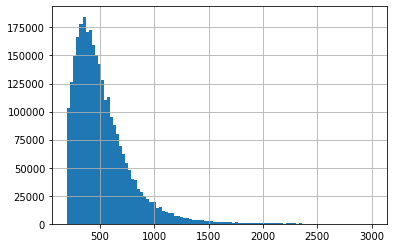

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.773594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8064
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 319


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6288
[100]	valid_0's huber: 64.807
[150]	valid_0's huber: 58.7057
[200]	valid_0's huber: 54.9032
[250]	valid_0's huber: 52.445
[300]	valid_0's huber: 50.6107
[350]	valid_0's huber: 49.1637
[400]	valid_0's huber: 48.1412
[450]	valid_0's huber: 47.2578
[500]	valid_0's huber: 46.4446
[550]	valid_0's huber: 45.7418
[600]	valid_0's huber: 45.1326
[650]	valid_0's huber: 44.54
[700]	valid_0's huber: 44.0341
[750]	valid_0's huber: 43.5733
[800]	valid_0's huber: 43.1409
[850]	valid_0's huber: 42.7908
[900]	valid_0's huber: 42.4336
[950]	valid_0's huber: 42.0855
[1000]	valid_0's huber: 41.8207
[1050]	valid_0's huber: 41.5823
[1100]	valid_0's huber: 41.3251
[1150]	valid_0's huber: 41.0316
[1200]	valid_0's huber: 40.8303
[1250]	valid_0's huber: 40.5818
[1300]	valid_0's huber: 40.3665
[1350]	valid_0's huber: 40.1521
[1400]	valid_0's huber: 39.9557
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


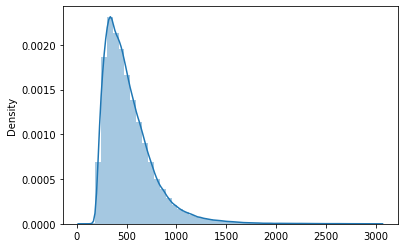

Fold 0 end
Fold 1 start
(2926581, 319)
y dist plot


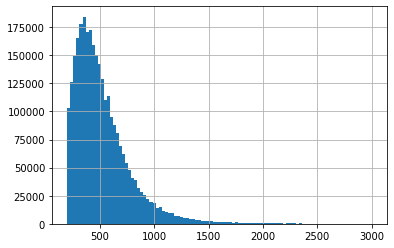

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.789255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8062
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 319


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.7083
[100]	valid_0's huber: 64.8126
[150]	valid_0's huber: 58.6797
[200]	valid_0's huber: 54.9941
[250]	valid_0's huber: 52.5842
[300]	valid_0's huber: 50.8198
[350]	valid_0's huber: 49.4119
[400]	valid_0's huber: 48.2847
[450]	valid_0's huber: 47.4118
[500]	valid_0's huber: 46.6174
[550]	valid_0's huber: 45.8323
[600]	valid_0's huber: 45.2063
[650]	valid_0's huber: 44.6371
[700]	valid_0's huber: 44.1628
[750]	valid_0's huber: 43.7747
[800]	valid_0's huber: 43.3414
[850]	valid_0's huber: 42.9418
[900]	valid_0's huber: 42.5618
[950]	valid_0's huber: 42.214
[1000]	valid_0's huber: 41.8769
[1050]	valid_0's huber: 41.5932
[1100]	valid_0's huber: 41.3622
[1150]	valid_0's huber: 41.0748
[1200]	valid_0's huber: 40.7777
[1250]	valid_0's huber: 40.5307
[1300]	valid_0's huber: 40.3197
[1350]	valid_0's huber: 40.0955
[1400]	valid_0's huber: 39.8859
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


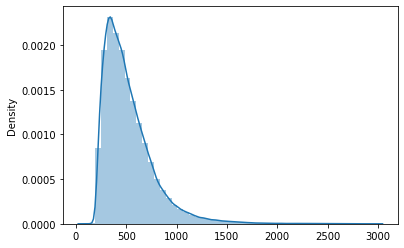

Fold 1 end
Fold 2 start
(2926581, 319)
y dist plot


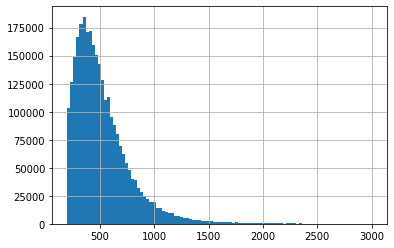

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.860745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8073
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 319


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5716
[100]	valid_0's huber: 64.7071
[150]	valid_0's huber: 58.5268
[200]	valid_0's huber: 54.9751
[250]	valid_0's huber: 52.447
[300]	valid_0's huber: 50.8209
[350]	valid_0's huber: 49.4859
[400]	valid_0's huber: 48.1729
[450]	valid_0's huber: 47.1572
[500]	valid_0's huber: 46.4216
[550]	valid_0's huber: 45.6869
[600]	valid_0's huber: 45.1087
[650]	valid_0's huber: 44.5806
[700]	valid_0's huber: 44.1189
[750]	valid_0's huber: 43.661
[800]	valid_0's huber: 43.2531
[850]	valid_0's huber: 42.8242
[900]	valid_0's huber: 42.4459
[950]	valid_0's huber: 42.1027
[1000]	valid_0's huber: 41.8234
[1050]	valid_0's huber: 41.6008
[1100]	valid_0's huber: 41.3243
[1150]	valid_0's huber: 41.0431
[1200]	valid_0's huber: 40.8323
[1250]	valid_0's huber: 40.6139
[1300]	valid_0's huber: 40.3943
[1350]	valid_0's huber: 40.1474
[1400]	valid_0's huber: 39.9602
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


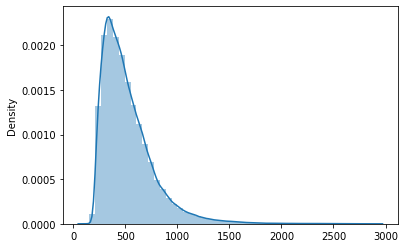

Fold 2 end
Fold 3 start
(2926581, 319)
y dist plot


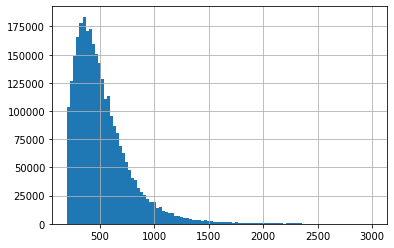

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.757004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8072
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 319


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4377
[100]	valid_0's huber: 64.7467
[150]	valid_0's huber: 58.6829
[200]	valid_0's huber: 55.1625
[250]	valid_0's huber: 52.6019
[300]	valid_0's huber: 50.6586
[350]	valid_0's huber: 49.2848
[400]	valid_0's huber: 48.2796
[450]	valid_0's huber: 47.3317
[500]	valid_0's huber: 46.5047
[550]	valid_0's huber: 45.6453
[600]	valid_0's huber: 45.0737
[650]	valid_0's huber: 44.5104
[700]	valid_0's huber: 44.0409
[750]	valid_0's huber: 43.5926
[800]	valid_0's huber: 43.1685
[850]	valid_0's huber: 42.7922
[900]	valid_0's huber: 42.4725
[950]	valid_0's huber: 42.1292
[1000]	valid_0's huber: 41.8142
[1050]	valid_0's huber: 41.5108
[1100]	valid_0's huber: 41.2473
[1150]	valid_0's huber: 40.9822
[1200]	valid_0's huber: 40.7474
[1250]	valid_0's huber: 40.539
[1300]	valid_0's huber: 40.3142
[1350]	valid_0's huber: 40.0998
[1400]	valid_0's huber: 39.9312
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


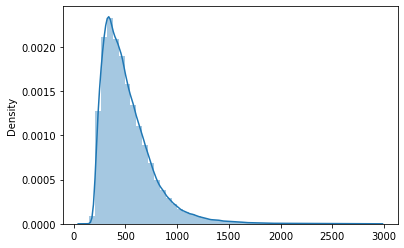

Fold 3 end
Fold 4 start
(2926581, 319)
y dist plot


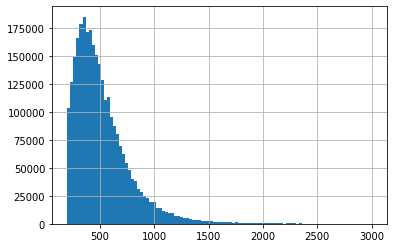

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.816931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8063
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 319


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.295
[100]	valid_0's huber: 64.6517
[150]	valid_0's huber: 58.6362
[200]	valid_0's huber: 54.9945
[250]	valid_0's huber: 52.5062
[300]	valid_0's huber: 50.723
[350]	valid_0's huber: 49.4089
[400]	valid_0's huber: 48.2495
[450]	valid_0's huber: 47.2313
[500]	valid_0's huber: 46.417
[550]	valid_0's huber: 45.7716
[600]	valid_0's huber: 45.1169
[650]	valid_0's huber: 44.5192
[700]	valid_0's huber: 44.0168
[750]	valid_0's huber: 43.5377
[800]	valid_0's huber: 43.1645
[850]	valid_0's huber: 42.7935
[900]	valid_0's huber: 42.4486
[950]	valid_0's huber: 42.0828
[1000]	valid_0's huber: 41.7811
[1050]	valid_0's huber: 41.4591
[1100]	valid_0's huber: 41.184
[1150]	valid_0's huber: 40.897
[1200]	valid_0's huber: 40.6761
[1250]	valid_0's huber: 40.4637
[1300]	valid_0's huber: 40.2558
[1350]	valid_0's huber: 40.0643
[1400]	valid_0's huber: 39.8717
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


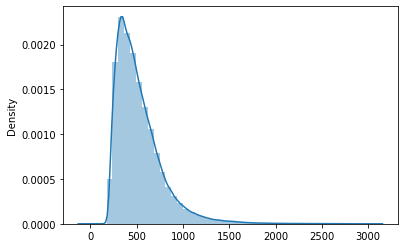

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [27]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_20_tail_cut_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.51029642292076

In [30]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [31]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [32]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [33]:
shap_summary_df.index = x_train.columns

In [34]:
shap_summary_df.to_csv(basedir + 'shap_20_tail_cut_2.csv')

In [35]:
#